# **8. Benchmark de modelos preentrenados para clasificación**
---
## **8.1 Introducción**
---

En este trabajo comparamos cuatro modelos preentrenados populares (entrenados con *ImageNet*s): **ResNet18** (nuestro baseline), **EfficientNet** (**B0** y **B3**), **MobileNet_V3_Large** y **ConvNeXt_Tiny**.

En el caso del **ResNet18** baseline, descongelamos únicamente la última capa del backbone para que pueda ajustarse durante el entrenamiento. En los otros tres modelos, el fine-tune se realiza desde **bloques anteriores**, lo que implica un mayor número de capas entrenables. En resumen, para esta primera parte del trabajo, entrenamos de la siguiente forma:

- ResNet18: desde fc (132.099 parámetros entrenables)  
- EfficientNet-B0: desde features.8 (740.867 parámetros entrenables)  
- MobileNet V3 Large: desde features.8 (3.125.539 parámetros entrenables)  
- ConvNeXt Tiny: desde features.7 (14.487.043 parámetros entrenables)

Luego, descongelamos este bloque/capa del backbone y reemplazamos la capa *fc* por una identidad (`nn.Identity()`), de modo que el modelo pueda conectarse a un clasificador personalizado compuesto por capas lineales, activaciones y dropout, encargado de realizar la clasificación final.

En resumen, el flujo es:

**backbone (bloque/capa descongelados/a entrenables) → capa identidad → clasificador personalizado**.

Este método aprovecha el aprendizaje transferido del backbone mientras ajusta la salida para nuestras clases específicas.

Para la optimización, consideramos tres valores diferentes de learning rate como principal hiperparámetro a ajustar, dado que los recursos y tiempo disponibles limitan la exploración de otros ajustes.

----------------

La elección de estas arquitecturas se basa en el trabajo *EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks* ([Paper en arXiv](https://arxiv.org/pdf/1905.11946)), así como en el análisis presentado en este [artículo](https://research.google/blog/efficientnet-improving-accuracy-and-efficiency-through-automl-and-model-scaling/). En particular, se seleccionó el modelo **EfficientNet_B0** (utilizado como baseline en dicho estudio) por mostrar un desempeño superior al **ResNet32**, como se ilustra en la siguiente figura (Figura 1 del paper).

Además, se incorporaron los modelos **MobileNet_V3_Large** y **ConvNeXt_Tiny** para ampliar la comparación. MobileNet_V3 también presenta buen desempeño usando *compound scaling* (método desarrollado para balancear profundidad, ancho y resolución de la red de manera eficiente), mientras que ConvNeXt_Tiny es una arquitectura moderna, eficiente y competitiva que no aparece en el estudio original.

Dado el método desarrollado en el estudio de EfficientNet y basado en la mejora de performance lograda mediante *compound scaling* (ver el paper para más detalles), en etapas posteriores se planea extender el análisis a modelos **EfficientNet** más avanzados, como los **B1**, **B3**, y sucesivos.


<img src="https://1.bp.blogspot.com/-oNSfIOzO8ko/XO3BtHnUx0I/AAAAAAAAEKk/rJ2tHovGkzsyZnCbwVad-Q3ZBnwQmCFsgCEwYBhgL/s1600/image3.png" alt="Descripción" height="400">

## **8.2 Entrenamiento de los modelos**
---

Configuración preliminar.

In [1]:
# Recomendado por PyTorch Lightning para aprovechar Tensor Cores (por la arquitectura de mi GPU)
import torch
torch.set_float32_matmul_precision('medium')

import shutil

# Borrar checkpoints anteriores
#shutil.rmtree("checkpoints", ignore_errors=True)

# Borrar logs anteriores
#shutil.rmtree("lightning_logs", ignore_errors=True)

Cargo tensores, creo datasets y creo los dataloaders.

In [2]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Cargar los tensores guardados
X_train, y_train = torch.load("train_normalizado.pt")
X_val, y_val = torch.load("val_normalizado.pt")
X_test, y_test = torch.load("test_normalizado.pt")

# Crear datasets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

# Crear loaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=False)
val_loader   = DataLoader(val_dataset, batch_size=512, shuffle=False, num_workers=4, pin_memory=False)
test_loader  = DataLoader(test_dataset, batch_size=512, shuffle=False, num_workers=4, pin_memory=False)

Defino funciones principales para entrenar modelos.

In [3]:
import torch
import torch.nn as nn
from lightning import LightningModule, Trainer
from lightning.pytorch.loggers import CSVLogger
from torchvision import models
import os
from lightning.pytorch.callbacks import EarlyStopping

def get_in_features(base_model):
    base_model.eval()
    with torch.no_grad():
        dummy = torch.randn(1, 3, 224, 224).to(next(base_model.parameters()).device)
        out = base_model(dummy)
    return out.shape[1]

class LitClassifier(LightningModule):
    def __init__(self, base_model_fn, weights, freeze_layer_name, num_classes=3, lr=3e-5):
        super().__init__()
        self.save_hyperparameters()
        self.training_outputs = []
        self.validation_outputs = []

        base_model = base_model_fn(weights=weights)
        unfreeze = False
        for name, param in base_model.named_parameters():
            if freeze_layer_name in name:
                unfreeze = True
            param.requires_grad = unfreeze

        if hasattr(base_model, "fc"):
            base_model.fc = nn.Identity()
            in_features = get_in_features(base_model)
        elif hasattr(base_model, "classifier"):
            base_model.classifier = nn.Identity()
            in_features = get_in_features(base_model)

        self.model = nn.Sequential(
            base_model,
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

        self.loss_fn = nn.CrossEntropyLoss()
        self.lr = lr

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, _):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        self.training_outputs.append(loss.detach())
        return loss  

    def on_train_epoch_end(self):
        avg_loss = torch.stack(self.training_outputs).mean()
        self.log("train_loss", avg_loss, prog_bar=True, on_step=False, on_epoch=True)
        self.training_outputs.clear()

    def validation_step(self, batch, _):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        acc = (logits.argmax(1) == y).float().mean()
        self.validation_outputs.append({"val_loss": loss.detach(), "val_acc": acc.detach()})
        return None  

    def on_validation_epoch_end(self):
        avg_loss = torch.stack([x["val_loss"] for x in self.validation_outputs]).mean()
        avg_acc = torch.stack([x["val_acc"] for x in self.validation_outputs]).mean()
        self.log("val_loss", avg_loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("val_acc", avg_acc, prog_bar=True, on_step=False, on_epoch=True)
        self.validation_outputs.clear()
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)


def train_and_test_models(train_loader, val_loader, test_loader):
    model_defs = [
        (models.resnet18, models.ResNet18_Weights.DEFAULT, "fc"),
        (models.efficientnet_b0, models.EfficientNet_B0_Weights.DEFAULT, "features.8"),
        (models.mobilenet_v3_large, models.MobileNet_V3_Large_Weights.DEFAULT, "features.8"),
        (models.convnext_tiny, models.ConvNeXt_Tiny_Weights.DEFAULT, "features.7"),
    ]

    learning_rates = [1e-4, 3e-5, 1e-5]

    os.makedirs("checkpoints", exist_ok=True)
    results = {}
    history = {}

    for lr in learning_rates:
        for fn, w, freeze_name in model_defs:
            name = fn.__name__
            print(f"Entrenando {name} con lr={lr}")
            logger = CSVLogger("lightning_logs", name=f"{name}_lr{lr}")
            early_stop_callback = EarlyStopping(
                monitor="val_loss",
                min_delta=0.001,
                patience=5,
                verbose=True,
                mode="min"
            )
                
            model = LitClassifier(fn, w, freeze_name, num_classes=3, lr=lr)
            trainer = Trainer(
                max_epochs=30,
                accelerator="gpu" if torch.cuda.is_available() else "cpu",
                logger=logger,
                callbacks=[early_stop_callback]
            )
            trainer.fit(model, train_loader, val_loader)

            checkpoint_path = f"checkpoints/{name}_lr{lr}_final.ckpt"
            trainer.save_checkpoint(checkpoint_path)

            metrics_df = logger.experiment.metrics
            history[f"{name}_lr{lr}"] = metrics_df

            model.eval()
            all_preds, all_labels = [], []
            for x, y in test_loader:
                x = x.to(model.device)
                with torch.no_grad():
                    preds = model(x).argmax(1)
                    all_preds.append(preds.cpu())
                    all_labels.append(y)
            results[f"{name}_lr{lr}"] = {
                "preds": torch.cat(all_preds),
                "labels": torch.cat(all_labels)
            }

    return results, history

In [4]:
# Descomentar para ejecutar el entrenamiento
#results, history = train_and_test_models(train_loader, val_loader, test_loader)

In [5]:
# Descomentar para ejecutar el entrenamiento
#mn_8_results, mn_8_history = train_and_test_models(train_loader, val_loader, test_loader)

In [6]:
# Guardar resultados y métricas
import pickle

#torch.save(results, "results.pt")
#torch.save(history, "history.pt")
results = torch.load("results.pt")
history = torch.load("history.pt")

#torch.save(mn_8_results, "mn_8_results.pt")
#torch.save(mn_8_history, "mn_8_history.pt")

#mn_8_results = torch.load("mn_8_results.pt")
#mn_8_history = torch.load("mn_8_history.pt")

A continuación se muestran la pérdida (**loss**) en entrenamiento y validación, así como la precisión (**accuracy**), todas en función de las épocas. Estos gráficos muestran que, en general, los modelos generalizan bien y no presentan sobreajuste, ya que el *early stopping* con una paciencia de 5 detiene el entrenamiento cuando empieza a aparecer el patrón típico de aumento de la pérdida de validación acompañado de una disminución sostenida de la pérdida de entrenamiento.

En general, los modelos presentan comportamientos durante el entrenamiento que dependen del *learning rate* utilizado. Por ejemplo, basado en la pérdida de validación, con el *learning rate* más pequeño los modelos ConvNeXt Tiny y MobileNet V3 Large no muestran signos claros de sobreajuste, mientras que con los *learning rates* más grandes, el *early stopping* entra en juego de forma evidente. En el caso del ResNet18, con el *learning rate* más bajo, el entrenamiento se detiene en las primeras épocas debido al *early stopping*. Además, se observa que a medida que se aumenta el *learning rate*, los modelos tienden a mostrar mejoras consistentes en la precisión (**accuracy**).

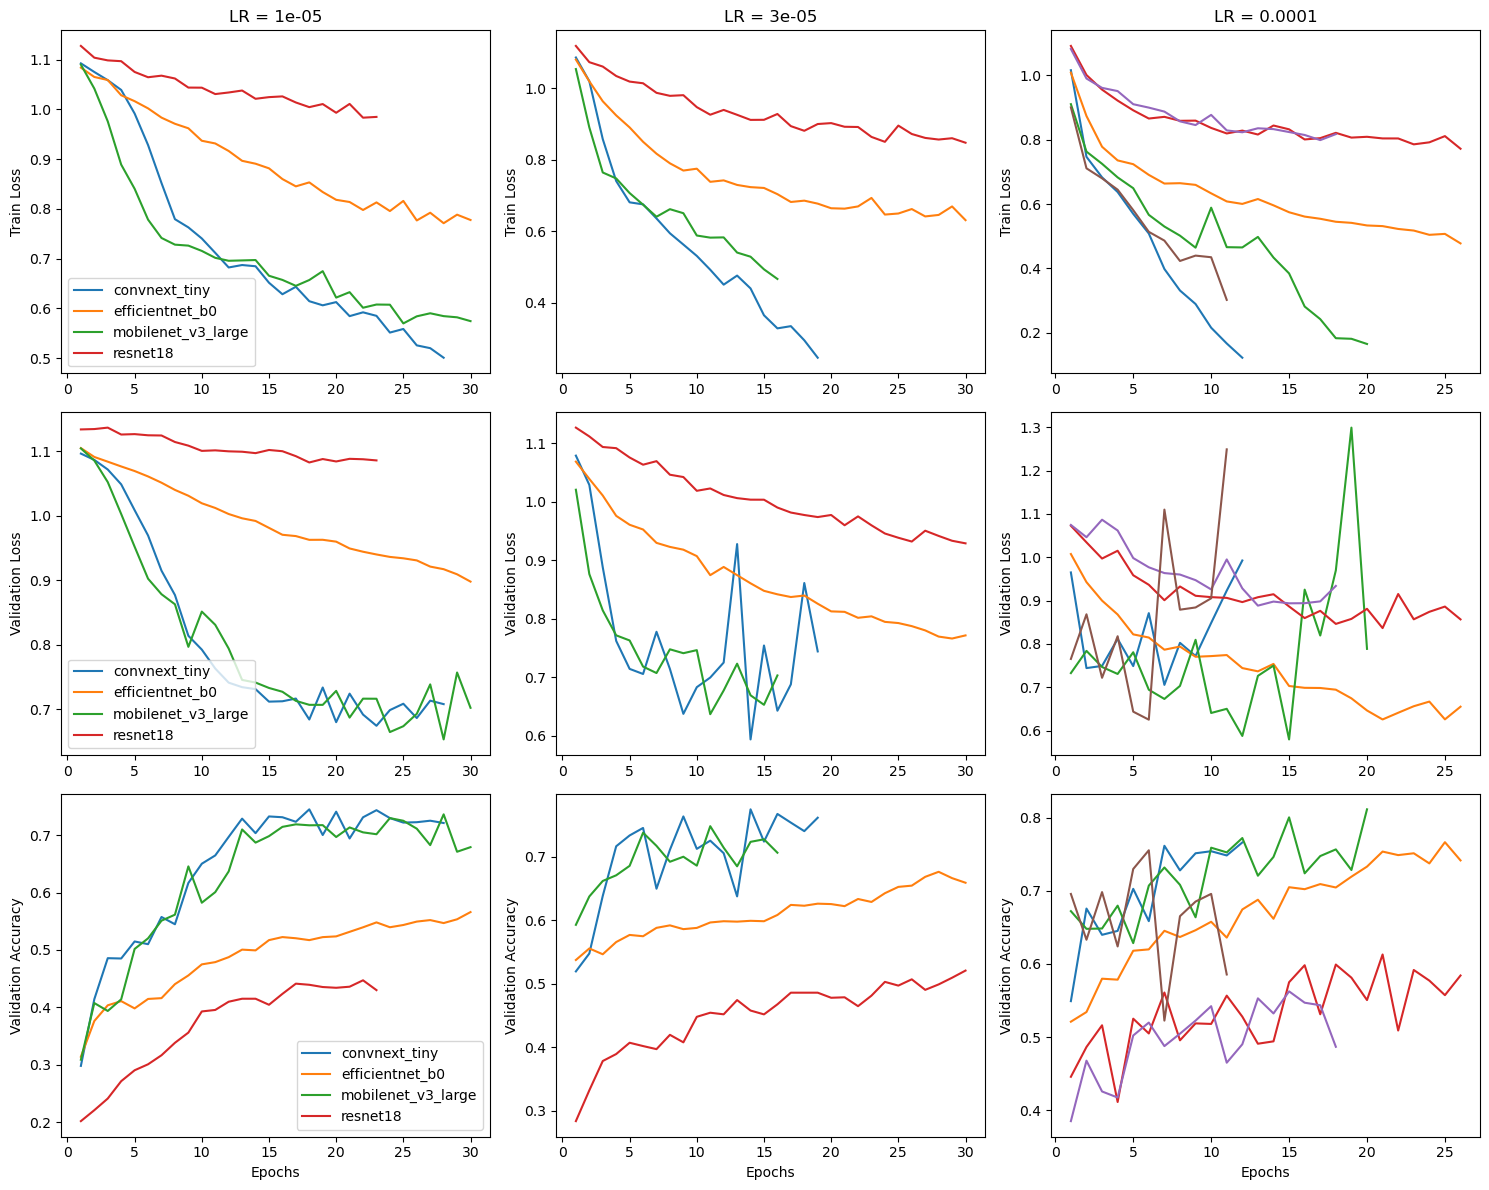

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import os

def load_history_from_logs(log_root="lightning_logs"):
    history = {}
    for folder in os.listdir(log_root):
        folder_path = os.path.join(log_root, folder)
        if not os.path.isdir(folder_path):
            continue
        version_path = os.path.join(folder_path, "version_0", "metrics.csv")
        if os.path.exists(version_path):
            df = pd.read_csv(version_path)
            history[folder] = df
    return history

history = load_history_from_logs()

lrs = sorted({float(k.split("_lr")[1]) for k in history.keys()})
modelos = sorted({k.split("_lr")[0] for k in history.keys()})

fig, axes = plt.subplots(3, len(lrs), figsize=(5*len(lrs), 12), sharex=False)

for col, lr in enumerate(lrs):
    for modelo in modelos:
        if "feature" in modelo:
            continue

        key = f"{modelo}_lr{lr}"
        if key not in history:
            continue

        df = history[key]

        train_loss_df = df[df['train_loss'].notna()]
        val_df = df[df['val_loss'].notna() & df['val_acc'].notna()]

        if not train_loss_df.empty:
            epochs_train = train_loss_df['epoch'] + 1
            train_loss = train_loss_df['train_loss']
            axes[0, col].plot(epochs_train, train_loss, linestyle='-', label=f"{modelo}")

        if not val_df.empty:
            epochs_val = val_df['epoch'] + 1
            val_loss = val_df['val_loss']
            val_acc = val_df['val_acc']
            axes[1, col].plot(epochs_val, val_loss, linestyle='-', label=f"{modelo}")
            axes[2, col].plot(epochs_val, val_acc, linestyle='-', label=f"{modelo}")

    axes[0, col].set_title(f"LR = {lr}")
    axes[0, col].set_ylabel("Train Loss")
    axes[1, col].set_ylabel("Validation Loss")
    axes[2, col].set_ylabel("Validation Accuracy")
    axes[2, col].set_xlabel("Epochs")

for row in range(3):
    axes[row, 0].legend(loc='best')

plt.tight_layout()
plt.show()

## **8.3 Comparación de modelos con matrices de confusión**
---

A continuación se muestran las matrices de **confusión** para los cuatro modelos, tanto en forma **nominal** como **normalizada**. Se emplea un *learning rate* de $1 \times 10^{-4}$, elegido como valor de referencia para los experimentos. El efecto de este hiperparámetro en el desempeño se analizará más adelante mediante la comparación de métricas como **accuracy**, **recall**, **F1** y un **puntaje personalizado**.

Se puede observar que el modelo MobileNet V3 Large junto con el ConvNeXt Tiny presentan los mejores resultados al predecir muy bien la clase *Normal*, bien la clase *Osteopenia*, y tener un comportamiento aceptable al predecir la clase *Osteoporosis*. El modelo EfficientNet-B0 predice muy bien la clase *Osteopenia*, predice bien la clase *Normal*, pero de forma regular la clase *Osteoporosis*. ResNet18 muestra una excelente predicción de la clase *Osteopenia*, pero desempeños regulares en las otras dos clases.


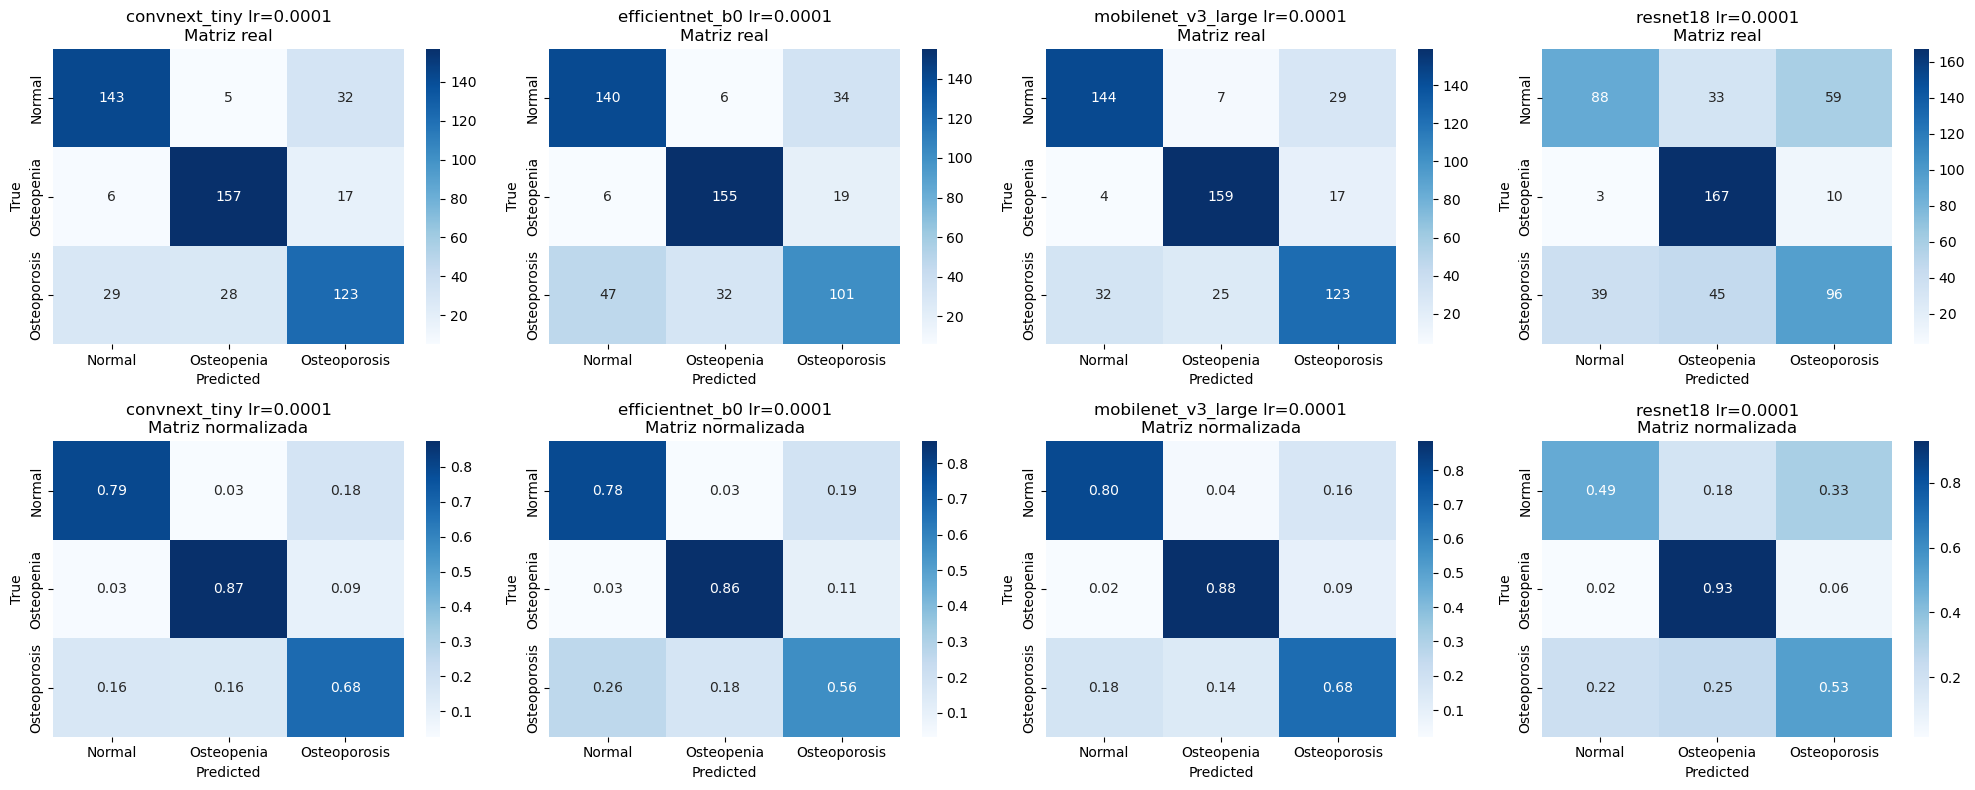

In [8]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

lr_target = 1e-4
model_names = sorted({k.split("_lr")[0] for k in results.keys()})

fig, axes = plt.subplots(2, len(model_names), figsize=(5 * len(model_names), 8))

for i, modelo in enumerate(model_names):
    key = f"{modelo}_lr{lr_target}"
    if key not in results:
        print(f"No hay resultados para {key}")
        continue

    y_true = results[key]["labels"].numpy()
    y_pred = results[key]["preds"].numpy()

    # Matriz real
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[0, i],
                xticklabels=['Normal', 'Osteopenia', 'Osteoporosis'],
                yticklabels=['Normal', 'Osteopenia', 'Osteoporosis'])
    axes[0, i].set_title(f"{modelo} lr={lr_target}\nMatriz real")
    axes[0, i].set_xlabel("Predicted")
    axes[0, i].set_ylabel("True")

    # Matriz normalizada por fila
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues", ax=axes[1, i],
                xticklabels=['Normal', 'Osteopenia', 'Osteoporosis'],
                yticklabels=['Normal', 'Osteopenia', 'Osteoporosis'])
    axes[1, i].set_title(f"{modelo} lr={lr_target}\nMatriz normalizada")
    axes[1, i].set_xlabel("Predicted")
    axes[1, i].set_ylabel("True")

plt.tight_layout()
plt.show()


## **8.4 Métricas adicionales**
---

- **Recall enfermo vs sano:** mide qué tan bien el modelo detecta a los pacientes enfermos (osteopenia u osteoporosis) sin confundirlos con sanos. No distingue entre tipos de enfermedad, solo sano vs enfermo.

- **F1 entre enfermedades:** evalúa el equilibrio entre precisión y recall al clasificar las distintas enfermedades, solo considerando pacientes enfermos. Esta métrica distingue entre osteopenia y osteoporosis.

- **Puntaje diagnóstico (Score Personalizado):** Evalua globalmente el desempeño clínico. Es un promedio ponderado de las métricas **recall** y **F1**. En este caso se asigna mayor peso al **recall** para reflejar mejor la capacidad del modelo de distinguir entre pacientes sanos y enfermos, mientras que la **F1** contribuye en menor medida para evaluar la diferenciación entre las dos patologías, que pueden tener distintos niveles de gravedad. Los pesos de este promedio ponderado pueden ajustarse según se considere necesario para enfatizar más o menos alguno de los aspectos.

In [9]:
from sklearn.metrics import recall_score, f1_score

# Defino las métricas

def compute_enfermo_vs_sano_recall(y_true, y_pred):
    # Convertir a binario: 0 = Normal, 1 = Enfermo (Osteopenia u Osteoporosis)
    y_true_bin = [0 if x == 0 else 1 for x in y_true]
    y_pred_bin = [0 if x == 0 else 1 for x in y_pred]
    return recall_score(y_true_bin, y_pred_bin)

def compute_enfermedades_f1(y_true, y_pred):
    # Filtro solo los casos enfermos
    y_true_sub = [x for x in y_true if x != 0]
    y_pred_sub = [p for x, p in zip(y_true, y_pred) if x != 0]
    return f1_score(y_true_sub, y_pred_sub, average='macro') 

def diagnostic_score(y_true, y_pred, alpha=0.7, beta=0.3):
    recall = compute_enfermo_vs_sano_recall(y_true, y_pred)
    f1_enf = compute_enfermedades_f1(y_true, y_pred)
    # Combino recall y f1 con pesos alpha y beta
    return alpha * recall + beta * f1_enf

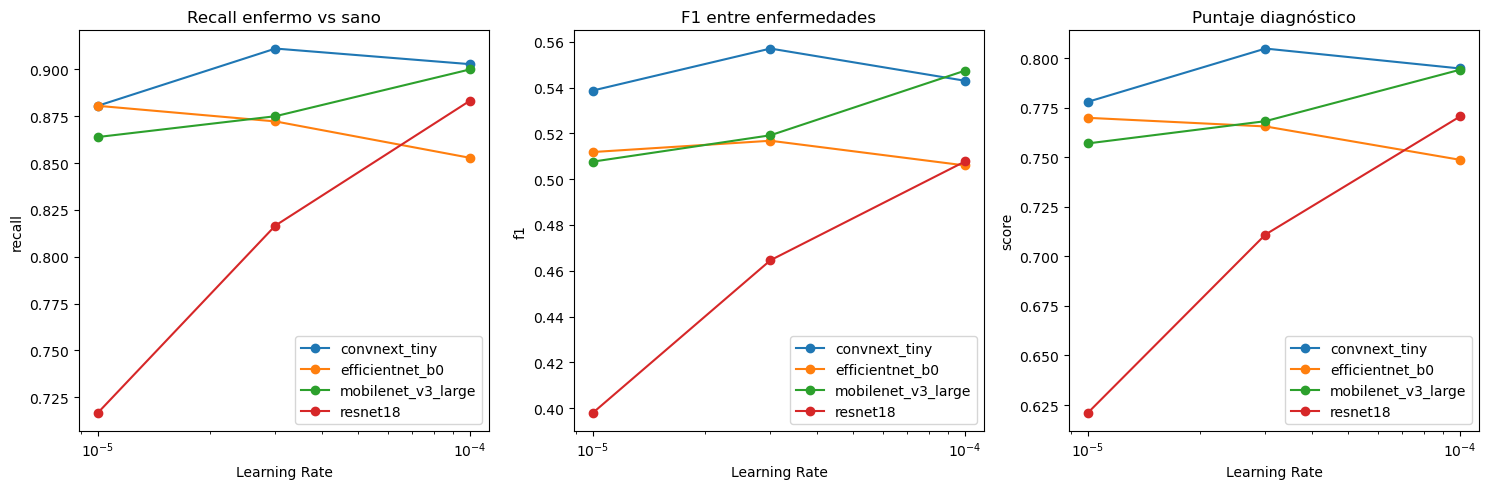

In [10]:
import pandas as pd

# Guardar métricas en lista
data = []
for key, vals in results.items():
    model_name, lr_str = key.split("_lr")
    lr = float(lr_str)
    
    y_true = vals["labels"].numpy()
    y_pred = vals["preds"].numpy()
    
    recall = compute_enfermo_vs_sano_recall(y_true, y_pred)
    f1 = compute_enfermedades_f1(y_true, y_pred)
    score = diagnostic_score(y_true, y_pred)
    
    data.append({
        "modelo": model_name,
        "lr": lr,
        "recall": recall,
        "f1": f1,
        "score": score
    })

df = pd.DataFrame(data)
df = df.sort_values(by=["lr", "modelo"])

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False)

metricas = ["recall", "f1", "score"]
titulos = ["Recall enfermo vs sano", "F1 entre enfermedades", "Puntaje diagnóstico"]

for ax, metrica, titulo in zip(axes, metricas, titulos):
    for modelo, subdf in df.groupby("modelo"):
        ax.plot(subdf["lr"], subdf[metrica], marker="o", label=modelo)
    ax.set_title(titulo)
    ax.set_xlabel("Learning Rate")
    ax.set_ylabel(metrica)
    ax.set_xscale("log")  
    ax.legend()

plt.tight_layout()
plt.show()


Basado en las métricas, los modelos que muestran un desempeño más consistente para las tres *learning rates* utilizadas son ConvNeXt Tiny, EfficientNet-B0 y MobileNet V3 Large. Por otro lado, ResNet18 presenta una mayor variabilidad en las métricas según la *learning rate* utilizada. Esto indica que este hiperparámetro tiene diferente sensibilidad según el modelo. Es importante realizar una búsqueda adecuada del mismo para asegurar que cada modelo alcance su mejor desempeño.

Sería conveniente analizar la performance de nuevos modelos, considerando los mismos *backbones* pero con más bloques/capas descongeladas. Además, teniendo en cuenta los resultados del paper mostrado en la introducción de esta notebook, se explora la utilización del modelo EfficientNet-B3, ya que presenta una mejora notable en la *accuracy* con un incremento relativamente pequeño en la cantidad total de parámetros entrenables, ofreciendo un buen *trade-off* entre desempeño y complejidad del modelo.

# **9. Nuevos Modelos**
---

En esta etapa se evalúan diferentes esquemas de descongelado para los modelos. El baseline corresponde a ResNet18 con la última capa del backbone (*fc*) descongelada. Además, se prueba una variante de ResNet18 con más capas o bloques descongeladas (a partir de layer3), EfficientNet-B0 y MobileNet V3 Large descongelando a partir de los dos últimos bloques, y EfficientNet-B3 descongelando únicamente el último bloque.  

Para esta comparación se seleccionó un *learning rate* de 1e-4 a modo de referencia, sin que implique que sea el más adecuado. Debería analizarse también el comportamiento con otros *learning rates*, ya que, como se mostró previamente, el desempeño del modelo al predecir depende fuertemente de este parámetro.


In [11]:
def train_and_test_new_models(train_loader, val_loader, test_loader):
    model_defs = [
        (models.resnet18, models.ResNet18_Weights.DEFAULT, "fc"),
        (models.resnet18, models.ResNet18_Weights.DEFAULT, "layer3"),
        (models.efficientnet_b3, models.EfficientNet_B3_Weights.DEFAULT, "features.7"),
        (models.mobilenet_v3_large, models.MobileNet_V3_Large_Weights.DEFAULT, "features.6"),
        (models.efficientnet_b0, models.EfficientNet_B0_Weights.DEFAULT, "features.7"),
        (models.efficientnet_b0, models.EfficientNet_B0_Weights.DEFAULT, "features.6"),
    ]

    learning_rates = [1e-4]

    os.makedirs("checkpoints", exist_ok=True)
    results = {}
    history = {}

    for lr in learning_rates:
        for fn, w, freeze_name in model_defs:
            #name = fn.__name__
            name = f"{fn.__name__}_{freeze_name.replace('.', '_')}"
            print(f"Entrenando {name} con lr={lr}")
            #logger = CSVLogger("lightning_logs", name=f"{name}_lr{lr}")
            logger = CSVLogger("lightning_logs", name=f"{name}_lr{lr}")
            early_stop_callback = EarlyStopping(
                monitor="val_loss",
                min_delta=0.001,
                patience=5,
                verbose=True,
                mode="min"
            )
                
            model = LitClassifier(fn, w, freeze_name, num_classes=3, lr=lr)
            trainer = Trainer(
                max_epochs=40,
                accelerator="gpu" if torch.cuda.is_available() else "cpu",
                logger=logger,
                callbacks=[early_stop_callback]
            )
            trainer.fit(model, train_loader, val_loader)

            checkpoint_path = f"checkpoints/{name}_lr{lr}_final.ckpt"
            trainer.save_checkpoint(checkpoint_path)

            metrics_df = logger.experiment.metrics
            history[f"{name}_lr{lr}"] = metrics_df

            model.eval()
            all_preds, all_labels = [], []
            for x, y in test_loader:
                x = x.to(model.device)
                with torch.no_grad():
                    preds = model(x).argmax(1)
                    all_preds.append(preds.cpu())
                    all_labels.append(y)
            results[f"{name}_lr{lr}"] = {
                "preds": torch.cat(all_preds),
                "labels": torch.cat(all_labels)
            }

    return results, history

In [12]:
#new_results, new_history = train_and_test_new_models(train_loader, val_loader, test_loader)

#torch.save(new_results, "new_results.pt")
#torch.save(new_history, "new_history.pt")

In [13]:
new_results = torch.load("new_results.pt")
new_history = torch.load("new_history.pt")

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def load_history_from_logs(log_root="lightning_logs"):
    history = {}
    for folder in os.listdir(log_root):
        folder_path = os.path.join(log_root, folder)
        if not os.path.isdir(folder_path):
            continue
        version_path = os.path.join(folder_path, "version_0", "metrics.csv")
        if os.path.exists(version_path):
            df = pd.read_csv(version_path)
            history[folder] = df
    return history

A continuación se muestran las curvas de pérdida en entrenamiento (**Train Loss**), pérdida en validación (**Validation Loss**) y precisión en validación (**Validation Accuracy**) para los seis modelos presentados. Al igual que en los análisis anteriores, se utiliza *early stopping* para evitar que los modelos se sobreajusten durante el entrenamiento.

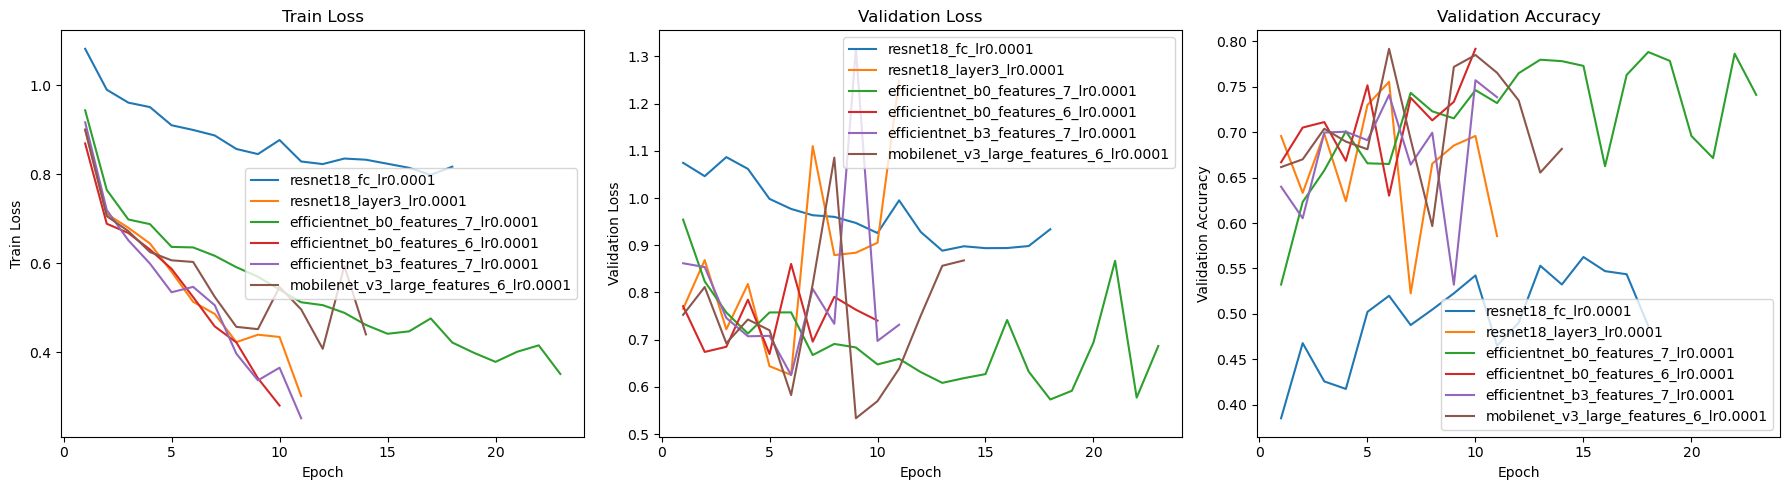

In [15]:

model_folders = [
    "resnet18_fc_lr0.0001",
    "resnet18_layer3_lr0.0001",
    "efficientnet_b0_features_7_lr0.0001",
    "efficientnet_b0_features_6_lr0.0001",
    "efficientnet_b3_features_7_lr0.0001",
    "mobilenet_v3_large_features_6_lr0.0001"
]

fig, axes = plt.subplots(1, 3, figsize=(18, 5)) 

history = load_history_from_logs()

for model in model_folders:
    if model not in history:
        print(f"No encontrado: {model}")
        continue
    df = history[model]
    epochs_train = df.dropna(subset=['train_loss'])['epoch'] + 1
    train_loss = df.dropna(subset=['train_loss'])['train_loss']
    val_df = df.dropna(subset=['val_loss', 'val_acc'])
    epochs_val = val_df['epoch'] + 1
    val_loss = val_df['val_loss']
    val_acc = val_df['val_acc']
    
    axes[0].plot(epochs_train, train_loss, label=model)
    axes[1].plot(epochs_val, val_loss, label=model)
    axes[2].plot(epochs_val, val_acc, label=model)

axes[0].set_title("Train Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Train Loss")

axes[1].set_title("Validation Loss")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Validation Loss")

axes[2].set_title("Validation Accuracy")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Validation Accuracy")

for ax in axes:
    ax.legend(loc='best')

plt.tight_layout()
plt.show()

Comparando las tres métricas utilizadas (**recall**, **F1** y el **score personalizado**) podemos observar lo siguiente:

En términos de desempeño, los mejores modelos son MobileNet V3 Large (mejor **recall** y mejor **score personalizado**) y EfficientNet-B3 (mejor **F1**). Seguidos a estos se encuentran los modelos ResNet18 con la última capa descongelada (*fc*), es decir, el baseline, y las dos versiones de EfficientNet-B0 (con distinto número de capas descongeladas). El peor desempeño se observa en ResNet18 con las capas descongeladas a partir de la *layer3* (10.625.539 parámetros entrenables).

El desempeño de los modelos, como se vio, puede depender en mayor o menor medida del *learning rate* elegido. Para ResNet18, al descongelar capas a partir de *layer3*, el rendimiento obtenido con el *learning rate* actual es inferior al logrado al descongelar únicamente la *fc*. Esto sugiere que, aunque al descongelar más capas se aumente significativamente el número de parámetros entrenables (10.625.539 vs 132.099), podría ser necesario ajustar el *learning rate* para que el modelo aproveche completamente su capacidad y alcance su máximo potencial.

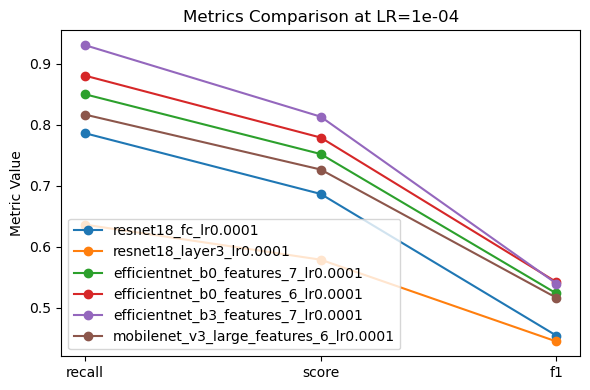

In [16]:
data = []

all_results = {**results, **new_results}

for key, vals in all_results.items():
    lr = float(key.split("_lr")[1])
    y_true = vals["labels"].numpy()
    y_pred = vals["preds"].numpy()
    recall = compute_enfermo_vs_sano_recall(y_true, y_pred)
    f1 = compute_enfermedades_f1(y_true, y_pred)
    score = diagnostic_score(y_true, y_pred)
    data.append({"modelo": key, "lr": lr, "recall": recall, "f1": f1, "score": score})

df = pd.DataFrame(data)
df_lr = df[df["lr"] == 0.0001]

metrics = ["recall", "score", "f1"]
x = np.arange(len(metrics))

fig, ax = plt.subplots(figsize=(6,4))

for model in model_folders:
    subdf = df_lr[df_lr["modelo"].str.startswith(model.split("_lr")[0])]
    if subdf.empty:
        continue
    values = [subdf[metric].values[0] for metric in metrics]
    ax.plot(x, values, marker='o', label=model)

ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylabel("Metric Value")
ax.set_title("Metrics Comparison at LR=1e-04")
ax.legend(loc='best')

plt.tight_layout()
plt.show()

In [21]:
# MobileNet V3 Large
key_mobilenet = "efficientnet_b3_features_7_lr0.0001"
y_true = all_results[key_mobilenet]["labels"].numpy()
y_pred = all_results[key_mobilenet]["preds"].numpy()
score_mobilenet = diagnostic_score(y_true, y_pred)
print("Score personalizado EfficientNet-B3: {:.3f}".format(score_mobilenet))

# ResNet18 baseline
key_resnet = "resnet18_lr3e-05"
y_true = all_results[key_resnet]["labels"].numpy()
y_pred = all_results[key_resnet]["preds"].numpy()
score_resnet = diagnostic_score(y_true, y_pred)
print("Score personalizado ResNet18 baseline: {:.3f}".format(score_resnet))


Score personalizado EfficientNet-B3: 0.813
Score personalizado ResNet18 baseline: 0.711


In [18]:
def train_and_test_new_models(train_loader, val_loader, test_loader):
    model_defs = [
        (models.mobilenet_v3_large, models.MobileNet_V3_Large_Weights.DEFAULT, "features.6"),
    ]

    learning_rates = [3e-5]

    os.makedirs("checkpoints", exist_ok=True)
    results = {}
    history = {}

    for lr in learning_rates:
        for fn, w, freeze_name in model_defs:
            #name = fn.__name__
            name = f"{fn.__name__}_{freeze_name.replace('.', '_')}"
            print(f"Entrenando {name} con lr={lr}")
            #logger = CSVLogger("lightning_logs", name=f"{name}_lr{lr}")
            logger = CSVLogger("lightning_logs", name=f"{name}_lr{lr}")
            early_stop_callback = EarlyStopping(
                monitor="val_loss",
                min_delta=0.001,
                patience=5,
                verbose=True,
                mode="min"
            )
                
            model = LitClassifier(fn, w, freeze_name, num_classes=3, lr=lr)
            trainer = Trainer(
                max_epochs=40,
                accelerator="gpu" if torch.cuda.is_available() else "cpu",
                logger=logger,
                callbacks=[early_stop_callback]
            )
            trainer.fit(model, train_loader, val_loader)

            checkpoint_path = f"checkpoints/{name}_lr{lr}_final.ckpt"
            trainer.save_checkpoint(checkpoint_path)

            metrics_df = logger.experiment.metrics
            history[f"{name}_lr{lr}"] = metrics_df

            model.eval()
            all_preds, all_labels = [], []
            for x, y in test_loader:
                x = x.to(model.device)
                with torch.no_grad():
                    preds = model(x).argmax(1)
                    all_preds.append(preds.cpu())
                    all_labels.append(y)
            results[f"{name}_lr{lr}"] = {
                "preds": torch.cat(all_preds),
                "labels": torch.cat(all_labels)
            }

    return results, history

#mn_results, mn_history = train_and_test_new_models(train_loader, val_loader, test_loader)

#torch.save(mn_results, "mn_results.pt")
#torch.save(mn_history, "mn_history.pt")

mn_results = torch.load("mn_results.pt")
mn_history = torch.load("mn_history.pt")

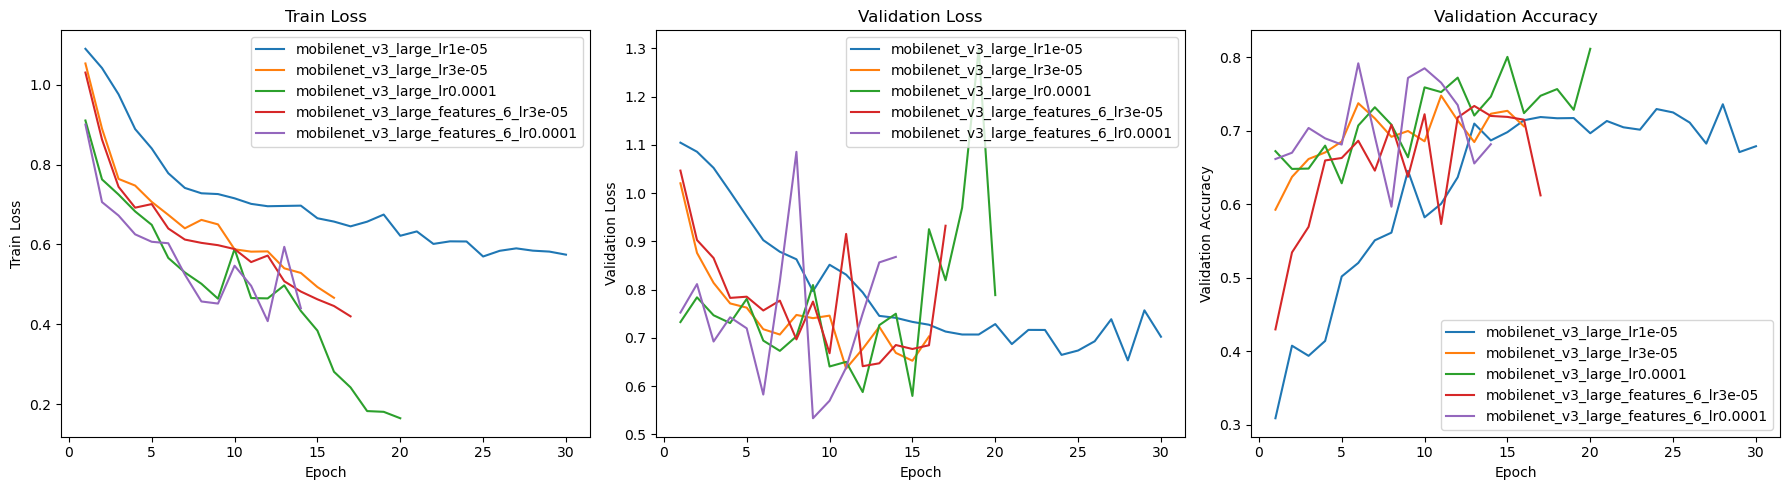

In [19]:
model_folders = [
    "mobilenet_v3_large_lr1e-05",
    "mobilenet_v3_large_lr3e-05",
    "mobilenet_v3_large_lr0.0001",
    "mobilenet_v3_large_features_6_lr3e-05",
    "mobilenet_v3_large_features_6_lr0.0001"
]

fig, axes = plt.subplots(1, 3, figsize=(18, 5)) 

history = load_history_from_logs()

for model in model_folders:
    if model not in history:
        print(f"No encontrado: {model}")
        continue
    df = history[model]
    epochs_train = df.dropna(subset=['train_loss'])['epoch'] + 1
    train_loss = df.dropna(subset=['train_loss'])['train_loss']
    val_df = df.dropna(subset=['val_loss', 'val_acc'])
    epochs_val = val_df['epoch'] + 1
    val_loss = val_df['val_loss']
    val_acc = val_df['val_acc']
    
    axes[0].plot(epochs_train, train_loss, label=model)
    axes[1].plot(epochs_val, val_loss, label=model)
    axes[2].plot(epochs_val, val_acc, label=model)

axes[0].set_title("Train Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Train Loss")

axes[1].set_title("Validation Loss")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Validation Loss")

axes[2].set_title("Validation Accuracy")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Validation Accuracy")

for ax in axes:
    ax.legend(loc='best')

plt.tight_layout()
plt.show()

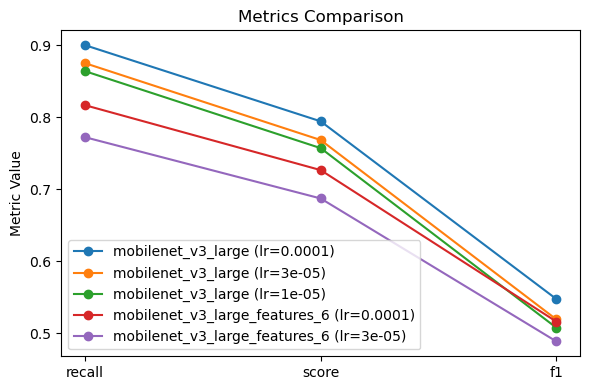

In [20]:
data = []

#all_results = {**results, **new_results, **mn_results, **mn_8_results}
all_results = {**results, **new_results, **mn_results}

for key, vals in all_results.items():
    if key not in model_folders:
        continue
    y_true = vals["labels"].numpy()
    y_pred = vals["preds"].numpy()
    recall = compute_enfermo_vs_sano_recall(y_true, y_pred)
    f1 = compute_enfermedades_f1(y_true, y_pred)
    score = diagnostic_score(y_true, y_pred)
    data.append({"modelo": key, "recall": recall, "f1": f1, "score": score})

df = pd.DataFrame(data)
metrics = ["recall", "score", "f1"]
x = np.arange(len(metrics))

fig, ax = plt.subplots(figsize=(6,4))

for idx, row in df.iterrows():
    values = [row[metric] for metric in metrics]
    model_name = "_".join(row['modelo'].split("_lr")[:-1])
    lr = row['modelo'].split("_lr")[1]
    ax.plot(x, values, marker='o', label=f"{model_name} (lr={lr})")

ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylabel("Metric Value")
ax.set_title("Metrics Comparison")
ax.legend(loc='best')

plt.tight_layout()
plt.show()


# **10. Conclusiones**
---

- Se partió del baseline **ResNet18** con la última capa descongelada, al que se añadió un modelo secuencial adicional después del backbone. Este bloque secuencial fue el mismo para todos los modelos utilizados.  
- Se probaron nuevos modelos descongelando distintos números de bloques, lo que permitió mejorar el desempeño del modelo baseline.  
- Para evaluar los modelos se utilizaron las métricas de **recall** y **F1**, considerando tanto la capacidad de distinguir entre pacientes sanos y enfermos como la diferenciación entre las dos patologías distintas.  
- Se definió un **score clínico personalizado** para comparar globalmente los modelos.  
- Los resultados obtenidos para los distintos modelos dependen fuertemente del *learning rate* seleccionado. La búsqueda de un valor adecuado para este hiperparámetro en cada caso es clave para alcanzar la máxima performance del modelo.
- El mejor modelo evaluado fue **EfficientNet-B3** con las bloques descongeladas a partir de *features.6* (4.271.357 parámetros entrenables). Con un *learning rate* de 1e-04, el **score personalizado** obtenido fue de **0.788**, superando al baseline **ResNet18** con la última capa descongelada (*fc*), que obtuvo un score de **0.738**.
